In [1]:
from datetime import datetime, date
import copy as cp
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from IPython.core.magic import register_cell_magic
from IPython.display import HTML, display

import statsmodels.formula.api as sm


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn import tree
from sklearn.metrics import roc_curve, auc, roc_auc_score


DATA_PATH = "/content/"
DATA_FN   = "cc_transactions.csv"
TODAY = date.today()

#  <span style="font-family: Palatino; font-size: 30px; color:purple">Business context </span>

We have been asked by the CSO (Chief  Security Officer), Xufeng, at MasterVista, a credit card company, to develop a fraud detection model to spot credit card transactions that may be suspicious.  MasterVista is concerned that some fraud-detection systems are not practical as they either cost too much to run or are difficult to explain to senior management and regulators.

Therefore, in addition to developing two models for predicting the probability that a prospective transaction is fraudulent, you will need to determine the value of each model, so that Xufeng can determine which model to recommend to the the Senior Management team.

### Helper function

In [2]:
def calc_age(birthday):
    today = date.today()
    return today.year - birthday.year - ((today.month, today.day) < (birthday.month, birthday.day))

#  <span style="font-family: Palatino; font-size: 30px; color:purple">The data </span>

The data can be found in the file `cc_tranactions.csv`.  

The dataset contains individual credit card transactions over a the period 01-01-2019 - 12-31-2021.  The transactions only represent a small subset of all users that we have sampled to keep the size of the dataset manageable.  The data dictionary is given below.

The data set contains 1,997,859 observations of 26 variables per transaction.

_(Note that for purposes of this home work, the data are synthetic, but based on a real data set.  We do this to avoid privacy issues.  Also note that we are making some simplifying assumptions about the costs and benefits of transactions, etc.)_

### Data Dictionary

 <!-- | __variable__   | __Description__ |
 | :--            | -:-             |
 | ` ssn `        | Social Security number
 | ` cc_num `     | Credit card number
 | ` first `      | First name
 | ` last `       | Last name
 | ` gender `     | Gender
 | ` street `     | Street address
 | ` city `       | City of residence
 | ` state `      | State of residence
 | ` zip `        | Postal code of residence
 | ` lat `        | Latitude of residence
 | ` long `       | Longitude of residence
 | ` city_pop   ` | Population of city of residence
 | ` job `        | Job title
 | ` dob `        | Date of birth
 | ` acct_num `   | User acct number
 | ` profile `    | Demographic cluster
 | ` trans_num `  | Transaction number
 | ` trans_date ` | Transaction date
 | ` trans_time ` | Transaction time
 | ` unix_time `  | UNIX time of transaction
 | ` category `   | Type of product
 | ` amt `        | Transaction amt
 | ` is_fraud `   | Dummy indicating fraud (1) or no-fraud (0)
 | ` merchant `   | Name of merchant executing transaction
 | ` merch_lat `  | Latitude of merchant location
 | ` merch_long ` | Longitude of merchant location
  -->

| Variable    | Description                         |
|------------ | ----------------------------------- |
| `ssn`       | Social Security number              |
| `cc_num`    | Credit card number                  |
| `first`     | First name                          |
| `last`      | Last name                           |
| `gender`    | Gender                              |
| `street`    | Street address                      |
| `city`      | City of residence                   |
| `state`     | State of residence                  |
| `zip`       | Postal code of residence            |
| `lat`       | Latitude of residence               |
| `long`      | Longitude of residence              |
| `city_pop`  | Population of city of residence     |
| `job`       | Job title                           |
| `dob`       | Date of birth                       |
| `acct_num`  | User acct number                    |
| `profile`   | Demographic cluster                 |
| `trans_num` | Transaction number                  |
| `trans_date`| Transaction date                    |
| `trans_time`| Transaction time                    |
| `unix_time` | UNIX time of transaction            |
| `category`  | Type of product                     |
| `amt`       | Transaction amt                     |
| `is_fraud`  | Dummy indicating fraud (1) or no-fraud (0) |
| `merchant`  | Name of merchant executing transaction |
| `merch_lat` | Latitude of merchant location        |
| `merch_long`| Longitude of merchant location       |


### Selected data summaries

#### `is_fraud`

| __label__   | __count__
| :--   | :-- |    
| 0  |  1,990,508
| 1  |    7,351

#### `profile`

 <!-- | __label__   | __count__
 | :--   | :-- |    
adults_2550_female_rural |  19738
adults_2550_female_urban | 573037
adults_2550_male_rural |    21969
adults_2550_male_urban |   497764
adults_50up_female_rural |   8756
adults_50up_female_urban | 299042
adults_50up_male_rural |    20862
adults_50up_male_urban |   303322
young_adults_female_rural |  7686
young_adults_female_urban    119580
young_adults_male_rural |    6577
young_adults_male_urban |  119526 -->

| __label__                | __count__   |
|:-------------------------|-------------:|
| adults_2550_female_rural | 19,738      |
| adults_2550_female_urban | 573,037     |
| adults_2550_male_rural   | 21,969      |
| adults_2550_male_urban   | 497,764     |
| adults_50up_female_rural | 8,756       |
| adults_50up_female_urban | 299,042     |
| adults_50up_male_rural   | 20,862      |
| adults_50up_male_urban   | 303,322     |
| young_adults_female_rural | 7,686      |
| young_adults_female_urban | 119,580    |
| young_adults_male_rural   | 6,577      |
| young_adults_male_urban   | 119,526    |


#### `category`

 | __Label__   | __count__
 | :--| --:|  
entertainment |   145,896 |
food_dining   |   150,670
gas_transport |   170,316
grocery_net   |    86,063
grocery_pos   |   187,250
health_fitness|   124,189
home          |   186,835
kids_pets     |   174,024
misc_net      |    90,653
misc_pos      |   131,483
personal_care |   141,152
shopping_net  |   146,755
shopping_pos  |   198,182
travel        |    64,391

### Load the data


In [3]:
df = pd.read_csv(DATA_PATH + DATA_FN)
df.head()

,Unnamed: 0,ssn,cc_num,first,last,gender,street,city,state,zip,...,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long
0,0,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,bebc2bdfbbe34520ce18d7ae79865a30,2021-07-01,02:47:05,1625122025,grocery_pos,343.23,1,Rutherford-Mertz,40.268151,-90.175379
1,1,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,12d1285fead521e4ced9e6c257e7c224,2021-07-02,13:53:00,1625248380,shopping_net,302.89,1,Predovic Inc,39.148351,-90.964542
2,2,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,18e577de79b3bf085047705609407063,2021-07-02,23:35:50,1625283350,shopping_net,959.42,1,Schmidt and Sons,40.576454,-90.010449
3,3,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,d88bf31e8e2834521556f483584bd91f,2021-07-01,23:21:46,1625196106,grocery_pos,982.90,1,"Kovacek, Dibbert and Ondricka",40.647832,-91.313098
4,4,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,938e1b0e3602e4bae52c398a381c6b11,2021-07-02,23:22:36,1625282556,shopping_net,1008.03,1,Lemke-Gutmann,40.775791,-89.907877


In [4]:
df.shape

(1997859, 27)

# <span style="font-family: Palatino; font-size: 24px; color:purple">Model building </span>

### Preprocessing

#### For each record, calculate the age of the customer based on `dob` and the day of the week of the transaction.

In [5]:
df['dob'] = pd.to_datetime(df['dob'])
df['trans_date'] = pd.to_datetime(df['trans_date'])

# Calculate age
df['age'] = df.apply(lambda row: calc_age(row['dob']), axis=1)

In [6]:
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date'].astype(str) + ' ' + df['trans_time'])

In [7]:
df.head()

,Unnamed: 0,ssn,cc_num,first,last,gender,street,city,state,zip,...,trans_time,unix_time,category,amt,is_fraud,merchant,merch_lat,merch_long,age,trans_date_trans_time
0,0,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,02:47:05,1625122025,grocery_pos,343.23,1,Rutherford-Mertz,40.268151,-90.175379,70,2021-07-01 02:47:05
1,1,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,13:53:00,1625248380,shopping_net,302.89,1,Predovic Inc,39.148351,-90.964542,70,2021-07-02 13:53:00
2,2,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,23:35:50,1625283350,shopping_net,959.42,1,Schmidt and Sons,40.576454,-90.010449,70,2021-07-02 23:35:50
3,3,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,23:21:46,1625196106,grocery_pos,982.90,1,"Kovacek, Dibbert and Ondricka",40.647832,-91.313098,70,2021-07-01 23:21:46
4,4,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,23:22:36,1625282556,shopping_net,1008.03,1,Lemke-Gutmann,40.775791,-89.907877,70,2021-07-02 23:22:36


#### Now use the function `datetime.weekday()` to calculate a new variable `dow` (day of the week) for each record, and use that information to construct binary feature `is_weekday`.
For more reference, please see: https://docs.python.org/3/library/datetime.html#datetime.date.weekday

In [8]:
df['dow'] = df['trans_date'].dt.weekday

df['is_weekday'] = (df['dow'] < 5).astype(int)

In [9]:
df.head()

,Unnamed: 0,ssn,cc_num,first,last,gender,street,city,state,zip,...,category,amt,is_fraud,merchant,merch_lat,merch_long,age,trans_date_trans_time,dow,is_weekday
0,0,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,grocery_pos,343.23,1,Rutherford-Mertz,40.268151,-90.175379,70,2021-07-01 02:47:05,3,1
1,1,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,shopping_net,302.89,1,Predovic Inc,39.148351,-90.964542,70,2021-07-02 13:53:00,4,1
2,2,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,shopping_net,959.42,1,Schmidt and Sons,40.576454,-90.010449,70,2021-07-02 23:35:50,4,1
3,3,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,grocery_pos,982.90,1,"Kovacek, Dibbert and Ondricka",40.647832,-91.313098,70,2021-07-01 23:21:46,3,1
4,4,167-80-6754,3526342637293304,Jonathan,Thomas,M,373 Sandra Brooks Suite 015,Arenzville,IL,62611,...,shopping_net,1008.03,1,Lemke-Gutmann,40.775791,-89.907877,70,2021-07-02 23:22:36,4,1


#### Perform any other preprocessing you think appropriate
(Be sure to note whether you are "peeking" at the test data (see below)  in those cases, you may need to split the data _before_ doing some preprocessing steps.)

In [12]:
from math import radians, cos, sin, asin, sqrt

df['hour'] = df['trans_date_trans_time'].dt.hour

def haversine_distance(lat1, long1, lat2, long2):
    # Convert decimal degrees to radians
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])

    # Haversine formula
    dlat = lat2 - lat1
    dlong = long2 - long1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlong/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

df['distance'] = df.apply(lambda row: haversine_distance(
    row['lat'], row['long'], row['merch_lat'], row['merch_long']), axis=1)

# Map 'gender' to numerical values
df['gender'] = df['gender'].map({'F': 0, 'M': 1})


# Define features and target variable
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']


#### Split the data into training and test samples.  
The test sample should include records with index 1,500,000 through the end of the data.

In [13]:
train_df = df.iloc[:1500000]
test_df = df.iloc[1500000:]

X_train = train_df.drop('is_fraud', axis=1)
y_train = train_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

### The current (incumbent) model
MasterVista has a model that was developed by an analyst at the bank.  The model has the following form:

 $$ \hat{y} = logit \left(\hat{\alpha} + \hat{\beta_1} log(age)+ \hat{\beta_2} log(city_{pop})+\hat{\beta_3} is\_{weekday} \right) $$

#### Estimate the MasterVista model on your training data. Use the test data to plot the ROC and calculate the AUC.

Optimization terminated successfully.
         Current function value: 0.022921
         Iterations 10


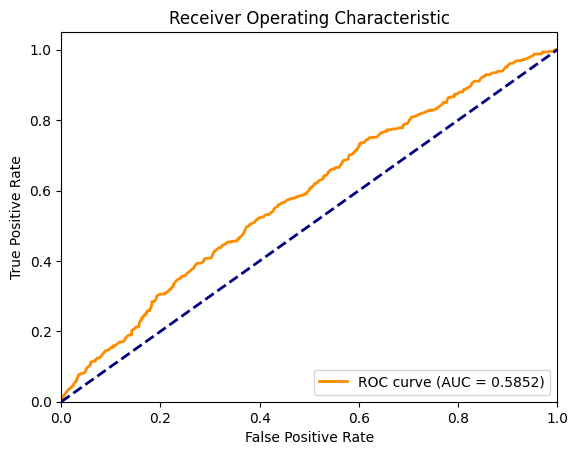

In [14]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

train_mv_df = X_train[['age', 'city_pop', 'is_weekday']].copy()
test_mv_df = X_test[['age', 'city_pop', 'is_weekday']].copy()

train_mv_df['age'] = train_mv_df['age'].apply(lambda x: np.log(x) if x > 0 else 0)
train_mv_df['city_pop'] = train_mv_df['city_pop'].apply(lambda x: np.log(x) if x > 0 else 0)
test_mv_df['age'] = test_mv_df['age'].apply(lambda x: np.log(x) if x > 0 else 0)
test_mv_df['city_pop'] = test_mv_df['city_pop'].apply(lambda x: np.log(x) if x > 0 else 0)

logit_model = sm.Logit(y_train, sm.add_constant(train_mv_df)).fit()

y_pred_prob = logit_model.predict(sm.add_constant(test_mv_df))

fpr_values, tpr_values, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr_values, tpr_values)

plt.figure()
plt.plot(fpr_values, tpr_values, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### Build your own GAM (with logit link function) to predict `is_fraud`.  Can you do better than MasterVista?
Only use the training data to build the model.  Use the test data to plot the ROC and calculate the AUC.

In [15]:
!pip install pygam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 11.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


/usr/local/lib/python3.10/dist-packages/pygam/links.py:149: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.10/dist-packages/pygam/pygam.py:627: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2
/usr/local/lib/python3.10/dist-packages/pygam/pygam.py:627: RuntimeWarning: overflow encountered in square
  self.link.gradient(mu, self.distribution) ** 2
/usr/local/lib/python3.10/dist-packages/pygam/links.py:149: RuntimeWarning: overflow encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
/usr/local/lib/python3.10/dist-packages/pygam/links.py:133: RuntimeWarning: overflow encountered in exp
  elp = np.exp(lp)
/usr/local/lib/python3.10/dist-packages/pygam/links.py:134: RuntimeWarning: invalid value encountered in divide
  return dist.levels * elp / (elp + 1)


did not converge
AUC of our GAM model: 0.9535


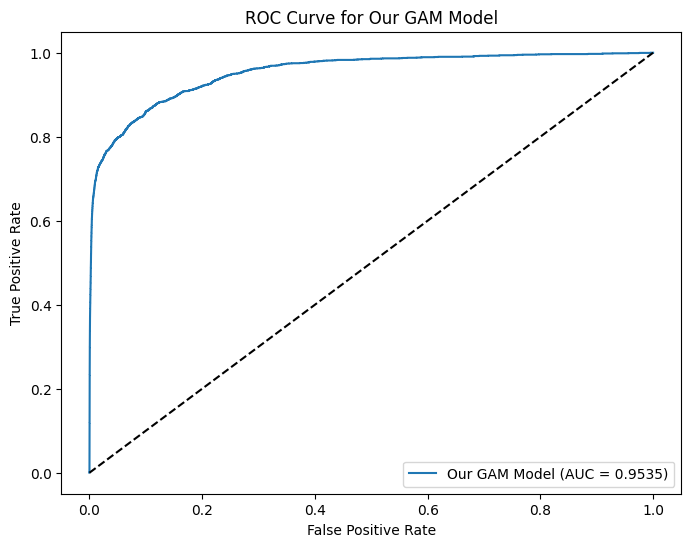

In [17]:
import pandas as pd
import numpy as np
from pygam import LogisticGAM, s, f
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


sample_fraction = 1
X_train_sampled = X_train.sample(frac=sample_fraction, random_state=42)
y_train_sampled = y_train.loc[X_train_sampled.index]

def prepare_gam_data(X):
    X = X.copy()
    le_category = LabelEncoder()
    le_gender = LabelEncoder()

    X['category_enc'] = le_category.fit_transform(X['category'])
    X['gender_enc'] = le_gender.fit_transform(X['gender'])

    X_gam = X[['amt', 'distance', 'age', 'hour', 'category_enc', 'gender_enc', 'is_weekday']]
    X_gam = X_gam.dropna()
    return X_gam

X_train_gam = prepare_gam_data(X_train_sampled)
X_test_gam = prepare_gam_data(X_test)

y_train_gam = y_train_sampled.loc[X_train_gam.index]
y_test_gam = y_test.loc[X_test_gam.index]

gam = LogisticGAM(
    s(0, n_splines=10) +  # 'amt'
    s(1, n_splines=10) +  # 'distance'
    s(2, n_splines=10) +  # 'age'
    s(3, n_splines=10) +  # 'hour'
    f(4) +                # 'category_enc'
    f(5) +                # 'gender_enc'
    f(6)                  # 'is_weekday'
).fit(X_train_gam.values, y_train_gam.values)

y_pred_prob_gam = gam.predict_proba(X_test_gam.values)

fpr_gam, tpr_gam, _ = roc_curve(y_test_gam, y_pred_prob_gam)
auc_gam = auc(fpr_gam, tpr_gam)

print(f"AUC of our GAM model: {auc_gam:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_gam, tpr_gam, label=f'Our GAM Model (AUC = {auc_gam:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Our GAM Model")
plt.legend(loc='lower right')
plt.show()


#### Now build a tree model to predict `is_fraud`.  Can you beat your GAM?
Only use the training data to build the model.  Use the test data to plot the ROC and calculate the AUC.

AUC of the Decision Tree model: 0.9743


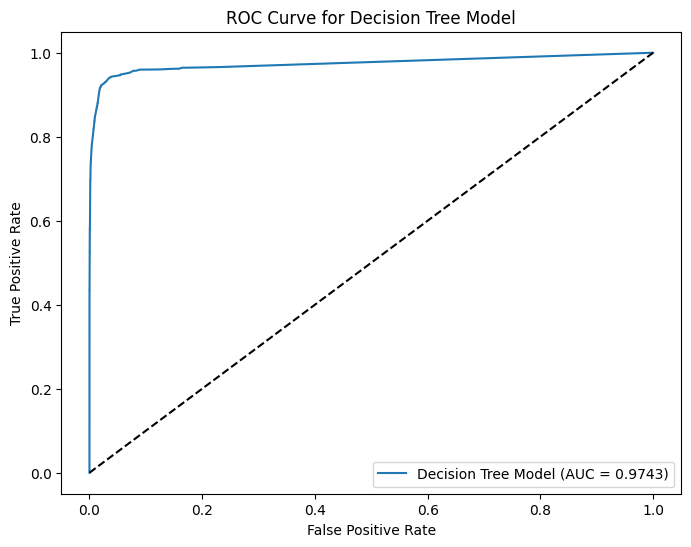

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    495700
           1       0.10      0.94      0.18      2159

    accuracy                           0.96    497859
   macro avg       0.55      0.95      0.58    497859
weighted avg       1.00      0.96      0.98    497859



In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt

def prepare_tree_data(X):
    X = X.copy()
    le_category = LabelEncoder()
    le_gender = LabelEncoder()

    X['category_enc'] = le_category.fit_transform(X['category'])
    X['gender_enc'] = le_gender.fit_transform(X['gender'])

    X_tree = X[['amt', 'distance', 'age', 'hour', 'category_enc', 'gender_enc', 'is_weekday']]
    X_tree = X_tree.dropna()  # Drop rows with NaN values
    return X_tree

X_train_tree = prepare_tree_data(X_train)
X_test_tree = prepare_tree_data(X_test)

y_train_tree = y_train.loc[X_train_tree.index]
y_test_tree = y_test.loc[X_test_tree.index]

dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced', max_depth=10)
dt_model.fit(X_train_tree, y_train_tree)

y_pred_prob_dt = dt_model.predict_proba(X_test_tree)[:, 1]  # Probability for the "is_fraud" class (1)

fpr_dt, tpr_dt, _ = roc_curve(y_test_tree, y_pred_prob_dt)
auc_dt = auc(fpr_dt, tpr_dt)

print(f"AUC of the Decision Tree model: {auc_dt:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree Model (AUC = {auc_dt:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Decision Tree Model")
plt.legend(loc='lower right')
plt.show()

print(classification_report(y_test_tree, dt_model.predict(X_test_tree)))


#  <span style="font-family: Palatino; font-size: 30px; color:purple">Finding  good cutoffs</span>

### MasterVista's fraud costs

MasterVista makes money in its credit card business through two primary sources:
- Merchant fees that are paid by the vendor to MasterVista to use the banking system
- Late fees that are paid by customers on outstanding balances

If there is a suspected fraudulent transaction, MasterVista incurs costs in one of two ways:
- In the event that there is a fraudulent transaction that is not prevented, MasterVista must reimburse the seller for the cost of the (fraudulently) purchased item
- In the event that a suspicious transaction is investigated, there is a cost associated with the investigation.

If a transaction is flagged it is verified manually.  If a flagged transaction is not authorized by the cardholder, it does not go through.  Otherwise, if it is flagged, but found to be valid, it is processed after the verification.

The table below outlines these costs, in percentage terms, for an average transaction. (In this section, we will make the simplifying assumption that the mean values purchases, etc. are sufficient for our analysis.  In practice, we would likely do this dynamically.)

| Variable                                | Value | Description                                              |
|----------------------------------------|-------|----------------------------------------------------------|
| Mean late fee profit pct (per trans)  | 2.3%  | Average percentage financed over more than one billing cycle (for approved purchases) |
| Mean loss pct on fraud                 | 150%  | Mean loss of purchase amount lost if fraudulent transaction goes through |
| Mean merchant fee profit pct           | 2%    | Mean fee paid by merchant for approved transactions, as a percentage of the transaction amount |
| Mean cost of verification              | 6%    | Mean cost of investigating a potentially fraudulent transaction before approving |

### Write down the cost-benefit matrix for MasterVista's operations


### Cost-Benefit Matrix

| **Class**           | **Net Impact (%)**         | **Reasoning**                                                                                                                                           |
|----------------------|----------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------|
| **True Positive (TP)**  | **+144%**                  | **Costs**: Verification cost = -6%.<br>**Benefits**: Fraud loss avoided = +150%.<br>Verification cost is added, but fraud loss is avoided.               |
| **False Positive (FP)** | **-1.7%**                  | **Costs**: Verification cost = -6%.<br>**Benefits**: Merchant fee = +2%.<br> Late fee = +2.3%.<br>The transaction is flagged but later approved after investigation.|
| **True Negative (TN)**  | **+4.3%**                  | **Costs**: None.<br>**Benefits**: Merchant fee = +2% + Late fee = +2.3%.<br>No verification cost, as the transaction is valid and processed directly.    |
| **False Negative (FN)** | **-145.7%**                | **Costs**: Fraud loss = -150%.<br>**Benefits**: Merchant fee = +2%.<br> Late fee = +2.3%.<br>Fraudulent transaction proceeds, resulting in a substantial loss. |


### Find the 'optimal' cutoff for
    1) MasterVista's model,
    2) your GAM, and
    3) your tree model;
### and plot the cost curves

In [19]:
late_fee_profit_pct = 0.023
merchant_fee_profit_pct = 0.02
fraud_loss_pct = 1.5
verification_cost_pct = 0.06

total_transactions = len(y_test)
fraud_transactions = y_test.sum()
p_D = fraud_transactions / total_transactions
p_ND = 1 - p_D

b_TN = (late_fee_profit_pct + merchant_fee_profit_pct)
b_TP = (fraud_loss_pct - verification_cost_pct)
c_FP = - (verification_cost_pct - merchant_fee_profit_pct - late_fee_profit_pct)
c_FN = - (fraud_loss_pct - merchant_fee_profit_pct - late_fee_profit_pct)

cutoffs = np.arange(0.0, 1.0, 0.01)
optimal_cutoff = 0
max_npv = -np.inf
npv_values = []
fp_costs = []
fn_costs = []
tp_profits = []
tn_profits = []


# NPV for each cutoff
for cutoff in cutoffs:
    y_pred = (y_pred_prob >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tn_profit = p_ND * b_TN * (tn/(tp+tn+fp+fn))
    fp_cost = p_ND * c_FP * (fp/(tp+tn+fp+fn))
    tp_profit = p_D * b_TP * (tp/(tp+tn+fp+fn))
    fn_cost = p_D * c_FN * (fn/(tp+tn+fp+fn))
    npv = tn_profit + fp_cost + tp_profit + fn_cost

    npv_values.append(npv)
    fp_costs.append(fp_cost)
    fn_costs.append(fn_cost)
    tp_profits.append(tp_profit)
    tn_profits.append(tn_profit)

    if npv > max_npv:
        max_npv = npv
        optimal_cutoff = cutoff

print("Optimal Cutoff:", optimal_cutoff)
print("Maximum NPV:", max_npv)

Optimal Cutoff: 0.01
Maximum NPV: 0.042600463602803604


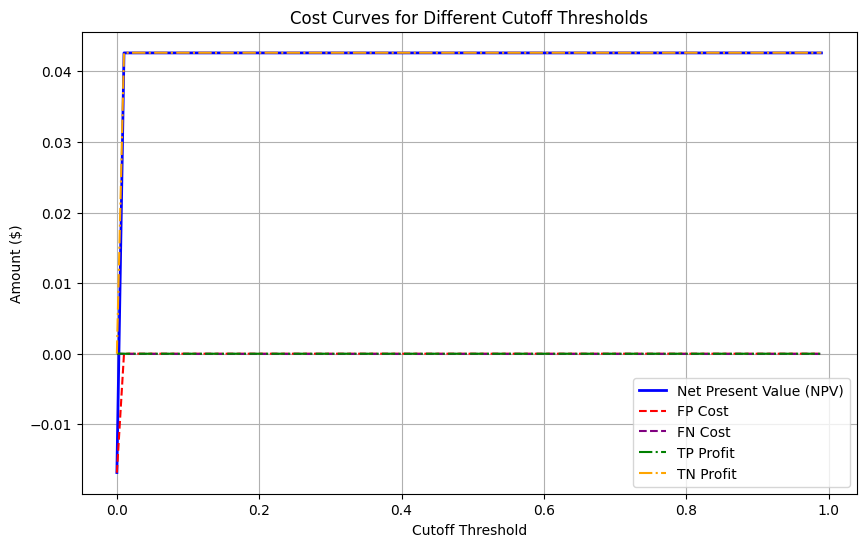

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(cutoffs, npv_values, label='Net Present Value (NPV)', color='blue', linewidth=2)
plt.plot(cutoffs, fp_costs, label='FP Cost', color='red', linestyle='--')
plt.plot(cutoffs, fn_costs, label='FN Cost', color='purple', linestyle='--')
plt.plot(cutoffs, tp_profits, label='TP Profit', color='green', linestyle='-.')
plt.plot(cutoffs, tn_profits, label='TN Profit', color='orange', linestyle='-.')

plt.xlabel("Cutoff Threshold")
plt.ylabel("Amount ($)")
plt.title("Cost Curves for Different Cutoff Thresholds")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
optimal_cutoff = 0.01
y_pred_binary = (y_pred_prob >= optimal_cutoff).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

print(f"True Positive Rate (TPR): {tpr:.4f}")
print(f"False Positive Rate (FPR): {fpr:.4f}")

True Positive Rate (TPR): 0.0000
False Positive Rate (FPR): 0.0000


Optimal Cutoff: 0.99
Maximum NPV: 0.042600463602803604


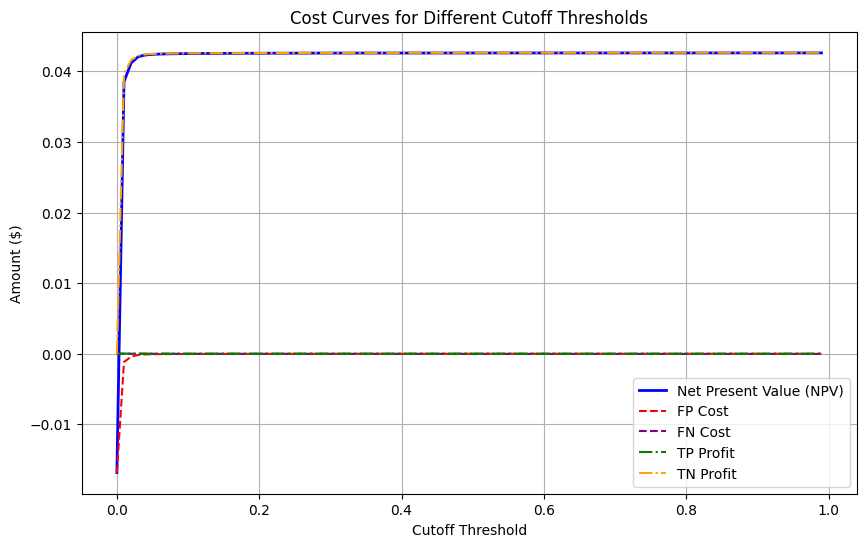

In [22]:
late_fee_profit_pct = 0.023
merchant_fee_profit_pct = 0.02
fraud_loss_pct = 1.5
verification_cost_pct = 0.06

total_transactions = len(y_test_gam)
fraud_transactions = y_test_gam.sum()
p_D = fraud_transactions / total_transactions
p_ND = 1 - p_D

b_TN = (late_fee_profit_pct + merchant_fee_profit_pct)
b_TP = (fraud_loss_pct - verification_cost_pct)
c_FP = - (verification_cost_pct - merchant_fee_profit_pct - late_fee_profit_pct)
c_FN = - (fraud_loss_pct - merchant_fee_profit_pct - late_fee_profit_pct)


cutoffs = np.arange(0.0, 1.0, 0.01)
optimal_cutoff_gam = 0
max_npv_gam = -np.inf
npv_values_gam = []
fp_costs_gam = []
fn_costs_gam = []
tp_profits_gam = []
tn_profits_gam = []


# Calculate NPV for each cutoff
for cutoff in cutoffs:
    y_pred_gam = (y_pred_prob_gam >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test_gam, y_pred_gam).ravel()

    tn_profit = p_ND * b_TN * (tn/(tp+tn+fp+fn))
    fp_cost = p_ND * c_FP * (fp/(tp+tn+fp+fn))
    tp_profit = p_D * b_TP * (tp/(tp+tn+fp+fn))
    fn_cost = p_D * c_FN * (fn/(tp+tn+fp+fn))
    npv = tn_profit + fp_cost + tp_profit + fn_cost

    npv_values_gam.append(npv)
    fp_costs_gam.append(fp_cost)
    fn_costs_gam.append(fn_cost)
    tp_profits_gam.append(tp_profit)
    tn_profits_gam.append(tn_profit)

    if npv > max_npv_gam:
        max_npv_gam = npv
        optimal_cutoff_gam = cutoff

print("Optimal Cutoff:", optimal_cutoff_gam)
print("Maximum NPV:", max_npv_gam)

plt.figure(figsize=(10, 6))
plt.plot(cutoffs, npv_values_gam, label='Net Present Value (NPV)', color='blue', linewidth=2)
plt.plot(cutoffs, fp_costs_gam, label='FP Cost', color='red', linestyle='--')
plt.plot(cutoffs, fn_costs_gam, label='FN Cost', color='purple', linestyle='--')
plt.plot(cutoffs, tp_profits_gam, label='TP Profit', color='green', linestyle='-.')
plt.plot(cutoffs, tn_profits_gam, label='TN Profit', color='orange', linestyle='-.')

plt.xlabel("Cutoff Threshold")
plt.ylabel("Amount ($)")
plt.title("Cost Curves for Different Cutoff Thresholds")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
optimal_cutoff = 0.99
y_pred_binary_gam = (y_pred_prob_gam >= optimal_cutoff).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test_gam, y_pred_binary_gam).ravel()

tpr_gam = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
fpr_gam = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate

print(f"True Positive Rate (TPR) for GAM: {tpr_gam:.4f}")
print(f"False Positive Rate (FPR) for GAM: {fpr_gam:.4f}")


True Positive Rate (TPR) for GAM: 0.0000
False Positive Rate (FPR) for GAM: 0.0000


Optimal Cutoff: 0.99
Maximum NPV: 0.04254999964474994


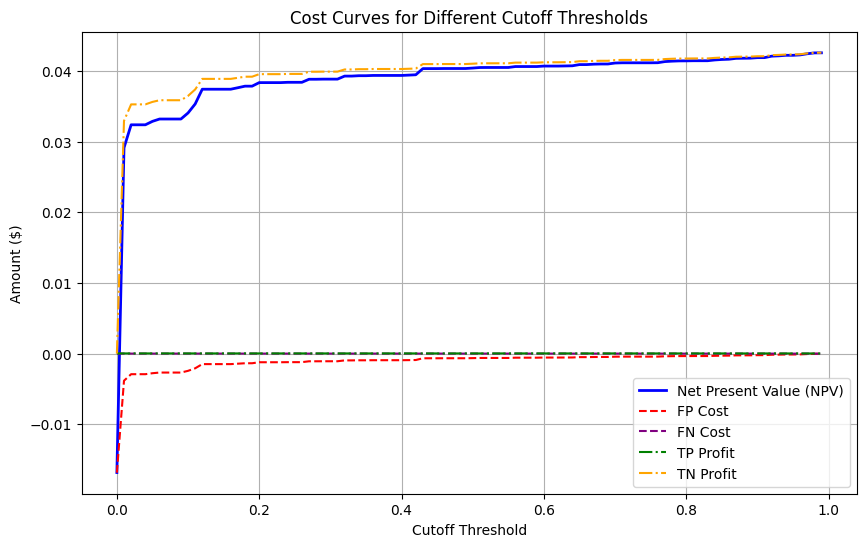

In [24]:
import numpy as np
from sklearn.metrics import confusion_matrix

late_fee_profit_pct = 0.023
merchant_fee_profit_pct = 0.02
fraud_loss_pct = 1.5
verification_cost_pct = 0.06

total_transactions = len(y_test_tree)
fraud_transactions = y_test_tree.sum()
p_D = fraud_transactions / total_transactions
p_ND = 1 - p_D

b_TN = (late_fee_profit_pct + merchant_fee_profit_pct)
b_TP = (fraud_loss_pct - verification_cost_pct)
c_FP = - (verification_cost_pct - merchant_fee_profit_pct - late_fee_profit_pct)
c_FN = - (fraud_loss_pct - merchant_fee_profit_pct - late_fee_profit_pct)

cutoffs = np.arange(0.0, 1.0, 0.01)
optimal_cutoff_rf = 0
max_npv_rf = -np.inf
npv_values_rf = []
fp_costs_rf = []
fn_costs_rf = []
tp_profits_rf = []
tn_profits_rf = []


# NPV for each cutoff
for cutoff in cutoffs:
    y_pred_rf = (y_pred_prob_dt >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test_tree, y_pred_rf).ravel()

    tn_profit = p_ND * b_TN * (tn/(tp+tn+fp+fn))
    fp_cost = p_ND * c_FP * (fp/(tp+tn+fp+fn))
    tp_profit = p_D * b_TP * (tp/(tp+tn+fp+fn))
    fn_cost = p_D * c_FN * (fn/(tp+tn+fp+fn))
    npv = tn_profit + fp_cost + tp_profit + fn_cost

    npv_values_rf.append(npv)
    fp_costs_rf.append(fp_cost)
    fn_costs_rf.append(fn_cost)
    tp_profits_rf.append(tp_profit)
    tn_profits_rf.append(tn_profit)

    if npv > max_npv_rf:
        max_npv_rf = npv
        optimal_cutoff_rf = cutoff

print("Optimal Cutoff:", optimal_cutoff_rf)
print("Maximum NPV:", max_npv_rf)

plt.figure(figsize=(10, 6))
plt.plot(cutoffs, npv_values_rf, label='Net Present Value (NPV)', color='blue', linewidth=2)
plt.plot(cutoffs, fp_costs_rf, label='FP Cost', color='red', linestyle='--')
plt.plot(cutoffs, fn_costs_rf, label='FN Cost', color='purple', linestyle='--')
plt.plot(cutoffs, tp_profits_rf, label='TP Profit', color='green', linestyle='-.')
plt.plot(cutoffs, tn_profits_rf, label='TN Profit', color='orange', linestyle='-.')

plt.xlabel("Cutoff Threshold")
plt.ylabel("Amount ($)")
plt.title("Cost Curves for Different Cutoff Thresholds")
plt.legend()
plt.grid(True)
plt.show()

In [25]:
optimal_cutoff = 0.99
y_pred_binary_rf = (y_pred_prob_dt >= optimal_cutoff).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test_tree, y_pred_binary_rf).ravel()

tpr_rf = tp / (tp + fn) if (tp + fn) > 0 else 0
fpr_rf = fp / (fp + tn) if (fp + tn) > 0 else 0

print(f"True Positive Rate (TPR) for Random Forest: {tpr_rf:.4f}")
print(f"False Positive Rate (FPR) for Random Forest: {fpr_rf:.4f}")


True Positive Rate (TPR) for Random Forest: 0.6948
False Positive Rate (FPR) for Random Forest: 0.0015


# <span style="font-family: Palatino; font-size: 30px; color:purple">Estimating economic value of models </span>

### Estimate `cost of fraud` with
    1) no model
    2) MasterVista's original model
    3) your GAM
    4) your tree model
### at optimal cutoff (per dollar loaned)

In [37]:
fraud_loss_pct = 1.5
verification_cost_pct = 0.06

total_transactions = len(y_test)
fraud_transactions = y_test.sum()

cost_no_model = fraud_transactions * fraud_loss_pct / len(y_test_gam)
print("Total Fraud Cost (No Model): $", cost_no_model)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
total = tp+fp +fn+tn

cost_fn = fn * fraud_loss_pct / total

cost_fp = fp  * verification_cost_pct / total

cost_mastervista = cost_fn + cost_fp
print("Total Fraud Cost per Dollar (MasterVista's Model): $", cost_mastervista)


Total Fraud Cost (No Model): $ 0.006504853783902672
Total Fraud Cost per Dollar (MasterVista's Model): $ 0.006504853783902672


In [38]:
total_transactions = len(y_test_gam)
fraud_transactions = y_test_gam.sum()

cost_no_model = fraud_transactions * fraud_loss_pct / len(y_test_gam)
print("Total Fraud Cost per Dollar (No Model): $", cost_no_model)

tn, fp, fn, tp = confusion_matrix(y_test_gam, y_pred_binary_gam).ravel()
total = tp+fp +fn+tn

cost_fn = fn * fraud_loss_pct / total

cost_fp = fp * verification_cost_pct / total

cost_gam = cost_fn + cost_fp
print("Total Fraud Cost per Dollar for GAM: $", cost_gam)

Total Fraud Cost per Dollar (No Model): $ 0.006504853783902672
Total Fraud Cost per Dollar for GAM: $ 0.006504853783902672


In [39]:
total_transactions = len(y_test_tree)
fraud_transactions = y_test_tree.sum()

cost_no_model = fraud_transactions * fraud_loss_pct / len(y_test_gam)
print("Total Fraud Cost per Dollar (No Model): $", cost_no_model)

tn, fp, fn, tp = confusion_matrix(y_test_tree, y_pred_binary_rf).ravel()
total = tp+fp +fn+tn

cost_fn = fn * fraud_loss_pct / total

cost_fp = fp * verification_cost_pct / total

cost_rf = cost_fn + cost_fp
print("Total Fraud Cost per Dollar (Tree): $", cost_rf)


Total Fraud Cost per Dollar (No Model): $ 0.006504853783902672
Total Fraud Cost per Dollar (Tree): $ 0.0020742017318156345


### Summarize costs of each approach:
#### Create a table that shows (a) the AUC of each model; (b) the optimal cutoff value for each model; and (c) the expected cost per transaction if each model is used at its optimal cutoff.

| Model       |    AUC   |Optimal cutoff (k)|Cost per $1 loaned|
|------------:|---------:|-----------------:|-----------------:|
| MV original |0.59          |0.01                  |0.006                  |
| my GLM      |0.9535          |0.99                 |0.006                 |
| my tree     |0.9743          |0.99                  |0.002
                |

#### Which model would you recommend that the bank use to minimize its lending costs?

# I would recommend the Tree model as its AUC is also high and also the costs per dollar loaned is very less as compared to others

### If the bank processes 300,000 transactions per day, with an average value of 25 dollars each, how much money would using the new model save the bank versus the current MasterVista model in the first 30 days of deploying the model?

In [40]:
saving_from_mastervista_model = 300000 * 25 * 30 * 0.006
saving_from_my_treemodel = 300000 * 25 * 30 * 0.002
print("Saving from MasterVista Model: $", saving_from_mastervista_model)
print("Saving from my Tree Model: $", saving_from_my_treemodel)

Saving from MasterVista Model: $ 1350000.0
Saving from my Tree Model: $ 450000.0


# <span style="font-family: Palatino; font-size: 30px; color:purple">Ooops! </span>

### Imagine that you now learn that the true rate of fraudulent transactions is 2%.  Recalculate the optimal cutoff for the MasterVista model.

In [43]:
true_base_rate = 0.02
calibrated_probabilities = true_base_rate * (
    (y_pred_prob - y_pred_prob * p_D) /
    (p_D - y_pred_prob * p_D +
     y_pred_prob * true_base_rate - p_D * true_base_rate)
)

Optimal Cutoff (Calibrated): 0.04
Maximum NPV (Calibrated): 0.042600463602803604


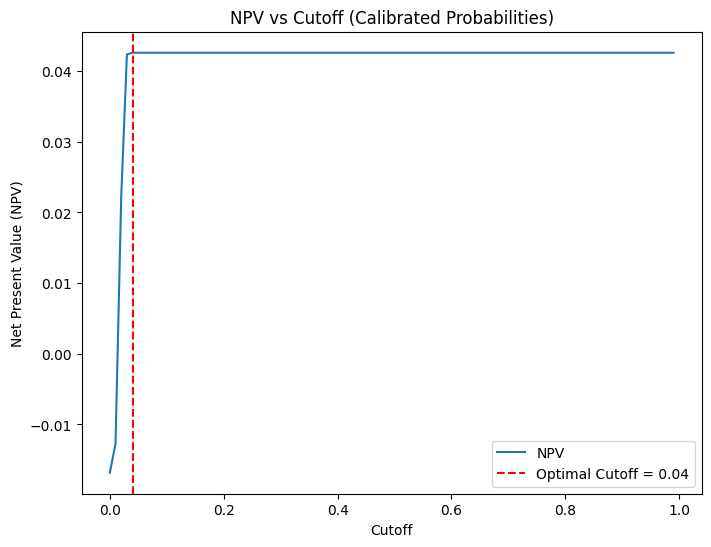

In [45]:
cutoffs = np.arange(0.0, 1.0, 0.01)
optimal_cutoff = 0
max_npv = -np.inf
npv_values = []
fp_costs = []
fn_costs = []
tp_profits = []
tn_profits = []

for cutoff in cutoffs:
    y_pred = (calibrated_probabilities >= cutoff).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    tn_profit = p_ND * b_TN * (tn / (tp + tn + fp + fn))
    fp_cost = p_ND * c_FP * (fp / (tp + tn + fp + fn))
    tp_profit = p_D * b_TP * (tp / (tp + tn + fp + fn))
    fn_cost = p_D * c_FN * (fn / (tp + tn + fp + fn))
    npv = tn_profit + fp_cost + tp_profit + fn_cost

    npv_values.append(npv)
    fp_costs.append(fp_cost)
    fn_costs.append(fn_cost)
    tp_profits.append(tp_profit)
    tn_profits.append(tn_profit)

    if npv > max_npv:
        max_npv = npv
        optimal_cutoff = cutoff

print("Optimal Cutoff (Calibrated):", optimal_cutoff)
print("Maximum NPV (Calibrated):", max_npv)


plt.figure(figsize=(8, 6))
plt.plot(cutoffs, npv_values, label="NPV")
plt.axvline(optimal_cutoff, color='r', linestyle='--', label=f'Optimal Cutoff = {optimal_cutoff:.2f}')
plt.xlabel("Cutoff")
plt.ylabel("Net Present Value (NPV)")
plt.title("NPV vs Cutoff (Calibrated Probabilities)")
plt.legend()
plt.show()

